# Training Models on Large Datasets on Palmetto Cluster using Dask

This Notebook is meant to be run on Palmetto Cluster's [JupyterHub](https://www.palmetto.clemson.edu/jupyterhub/).
Before running this notebook, please complete the setup described [here](https://www.palmetto.clemson.edu/palmetto/workflow_dask.html).

This notebook is based on the example at https://examples.dask.org/.
You can find similar examples and other Machine Learning worfklows there.

## 0. Before you begin

### 0.1 JupyterHub spawner options

If you are running this through Palmetto's Jupyterhub, the recommended spawner options are:

* Number of resource chunks: 4
* CPU cores per chunk: 16
* Memory per chunk: more than 16gb
* Walltime: at least 1 hour

### 0.2 Starting the Dask cluster

Before running the rest of this notebook, you should start a Dask Cluster. From the Jupyter dashboard, start a terminal (New->Terminal), and then run:

```
start-dask-cluster
```

The cluster takes about a minute to start up.

## 1. Introduction

In this notebook,
we'll demonstrate the use of [Dask-ML](https://dask-ml.readthedocs.io/en/latest/) for
performing K-means clustering of a sizeable dataset.

We'll run [`scikit-learn`](https://scikit-learn.org/stable/) k-means on a single node,
and compare the runtime with
[Dask-ML](https://dask-ml.readthedocs.io/en/latest/) k-means
using 4 nodes (a total of 64 cores).

## 2. Training on a single node (scikit-learn)

### 2.1 Generating the dataset

We use the `make_blobs` function below to create a dataset of 100000000 points that we'll cluster with KMeans.

In [11]:
import sklearn
import sklearn.datasets
import sklearn.cluster

N = 100000000
X, y = sklearn.datasets.make_blobs(n_samples=N, random_state=0, centers=3)

### 2.2 Clustering

Next, we use `scikit-learn`'s k-means algorithm to cluster the points. Note that this version of k-means can only run on a single node, and the dataset must fit in the RAM of that node.

In [38]:
km = sklearn.cluster.KMeans(n_clusters=3, n_init=1)

In [39]:
import time
t1 = time.time()
km.fit(X, y)
t2 = time.time()
print("Clustering took {} seconds.".format(t2-t1))

Clustering took 116.80316543579102 seconds.


### 2.3 Inspecting results

Below, we visualize the results of the clustering,
and check the locations of the centroids:

In [18]:
%matplotlib inline

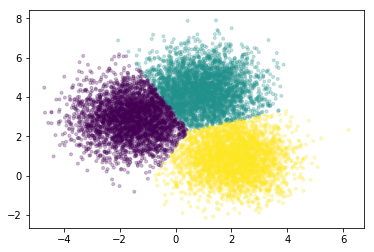

In [40]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000],
           cmap='viridis', alpha=0.25);

In [41]:
km.cluster_centers_

array([[-1.59657324,  2.88873064],
       [ 1.02561361,  4.37128981],
       [ 2.06665787,  0.87196219]])

## 3. Distributed training (Dask-ML)

### 3.1 Connecting to the dask cluster

First, we connect to the dask cluster we started from the Terminal earlier:

In [8]:
import getpass
username = getpass.getuser()

from dask.distributed import Client
e = Client(scheduler_file='/home/{}/dask-scheduler.json'.format(username))
e

Client Scheduler: tcp://10.125.8.32:8088 Dashboard: http://10.125.8.32:8787/status,Cluster Workers: 1 Cores: 16 Memory: 67.24 GB


In [9]:
import dask_ml.datasets
import dask_ml.cluster
import dask.array as da

### 3.2 Converting dataset to Dask Arrays

Below, we convert the NumPy arrays `X` and `y` into *Dask arrays* using the `da.from_array()` function.

In [12]:
chunk_size = 5000000
X, y = da.from_array(X, chunks=(chunk_size,-1)), da.from_array(y, chunks=(chunk_size,))

# X, y = dask_ml.datasets.make_blobs(n_samples=100000000,
#                                    chunks=chunk_size,
#                                    random_state=0,
#                                    centers=3)
X = X.persist()
y = y.persist()

### 3.3 Clustering

We use the Dask-ML version of
[KMeans](https://dask-ml.readthedocs.io/en/latest/modules/generated/dask_ml.cluster.KMeans.html)
which can work with Dask arrays.

The dataset is distributed among the nodes of the Dask cluster,
so it doesn't need to fit in the RAM of a single node.
The computations are parallelized on all cores of the Dask cluster,
so we expect to see a speedup over `scikit-learn`'s k-means.

In [19]:
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=1, oversampling_factor=10)

In [14]:
import time
t1 = time.time()
result = km.fit(X, y)
t2 = time.time()
print("Clustering took {} seconds.".format(t2-t1))

/home/atrikut/.conda/envs/dask_env/lib/python3.7/site-packages/dask/array/blockwise.py:204: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


Clustering took 45.11354160308838 seconds.


### 3.4 Inspecting results

We can compare the results with those previously obtained:

In [15]:
%matplotlib inline

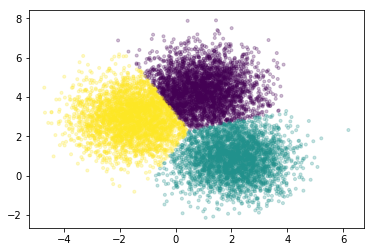

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000],
           cmap='viridis', alpha=0.25);

In [17]:
km.cluster_centers_

array([[ 1.03923118,  4.37508798],
       [ 2.06689921,  0.86960487],
       [-1.58513802,  2.89608514]])